# ARIMA modelling in Merriwa

Based on Yujing Yang's version.
* Note that the data file in L3_DEFAULT_0_20210216_Merriwa.csv has been augmented to include timestamps for 17/2/2021 at 10am. This is because data in this timestamp was completely missing prior. SARIMA requires complete datastamps.


TK adjusments - 15/9/2021
* ARIMA model function - change test and train period
* plotSARIMA function:
    * Incorporated rolling prediction window method. Refer to: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
    * Revised plots to only plot test period
    * Added index of agreement as error measure


In [42]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller as ADF
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
import datetime
from matplotlib import pyplot as plt
from scipy import stats
from itertools import product
from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize
from tqdm import tqdm_notebook
import warnings                                  # do not disturbe mode
import re
from datetime import datetime
from datetime import date
from datetime import timedelta
from glob import glob


from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean


data_path_CL51 = "D:\MSDS\DS Project\Data\ARIMA_data"

data_path = "D:\MSDS\DS Project\Data\CL51"

In [43]:
def read_csv(file1):
    with open(file1, 'r') as f:
        reader = pd.read_csv(f)
    ceilometer = reader[['# Time', 'bl_height']]
    return ceilometer

def read_all(cl51):
    df = pd.DataFrame(columns = ['# Time', 'bl_height'])
    for i in range(len(cl51)):
        file1 = data_path_CL51 + '\\'+ cl51[i] + '.csv'
        ceilometer = read_csv(file1)
        df = pd.concat([df, ceilometer], ignore_index=True)
    return df

def data_process():
    cl51_Merriwa = ['L3_DEFAULT_0_20210212_Merriwa','L3_DEFAULT_0_20210213_Merriwa',
               'L3_DEFAULT_0_20210214_Merriwa', 'L3_DEFAULT_0_20210215_Merriwa',
               'L3_DEFAULT_0_20210216_Merriwa','L3_DEFAULT_0_20210217_Merriwa', 
               'L3_DEFAULT_0_20210218_Merriwa']    
    Merriwa = read_all(cl51_Merriwa)
    cl51_df_Merriwa = Merriwa.replace(-999, np.nan)
    cl51_df_Merriwa['datetime'] = pd.to_datetime(cl51_df_Merriwa['# Time'], format='%d/%m/%Y %H:%M:%S')
    cl51_df_Merriwa = cl51_df_Merriwa.set_index('datetime')
    cl51_df_Merriwa = cl51_df_Merriwa.assign(revised_bl_height=cl51_df_Merriwa.bl_height.interpolate(method='time'))

    return cl51_df_Merriwa

def data_process_to_group(df):
    df_result = df.copy()
    
    df_result = pd.DataFrame(df_result['revised_bl_height'].resample('1H').mean().round(3)).ffill()
    df_result['# Time'] = df_result.index
    
    df_result = df_result.groupby([
        df_result['# Time'].dt.strftime('%Y-%m-%d').rename('Date'), 
        df_result['# Time'].dt.hour.rename('Hour')
    ])['revised_bl_height'].mean().reset_index(name='CL_BLH').set_index(['Date', 'Hour'])

    return df_result

def acfpacf(train):
    # acf pacf
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(train, lags=60, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(train, lags=60, ax=ax2)
    plt.savefig('./acfpacf.jpg')

# MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    

In [44]:
def parse_CTM(site, time_offset=10):
    # Careful! The seperator is not ',' but ', ' (space)
    df = pd.concat([pd.read_csv(file, sep=r'\s*,\s*', engine='python') for file in glob(f'CTM_ModelOutput/*{site}.csv')])

    # parse date string
    from datetime import timedelta
    df['Time'] = pd.to_datetime(df[['date', 'time']].astype(str).apply('-'.join, 1), format='%Y%m%d-%H') + timedelta(hours=time_offset)

    df = df.groupby([
        df['Time'].dt.strftime('%Y-%m-%d').rename('Date'), 
        df['Time'].dt.hour.rename('Hour')
    ])['mixing_height'].mean().reset_index(name='CTM_BLH').set_index(['Date', 'Hour'])

    return df

def convert_df_to_datetime_wrf(df):
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d_%H:%M:%S')+ timedelta(hours=10)
    
    #Set index to datetime
    df = df.set_index('datetime')
    
    #Keep the last index
    #As per Hiep response - 24/8/2021 - we keep last value

    df = df[~df.index.duplicated(keep = 'last')]
    
    df = df.reset_index()
    #Set index to datetime
    df = df.groupby([
        df['datetime'].dt.strftime('%Y-%m-%d').rename('Date'), 
        df['datetime'].dt.hour.rename('Hour')
    ])['WRF PBLH'].mean().reset_index(name='WRF_BLH').set_index(['Date', 'Hour'])

    
    return df

In [56]:
'''
2. Import WRF data
'''

data_path = "D:\MSDS\DS Project\Data"

wrf_data_path = "\\WRF"

wrf_data_fn_merriwa = ['PBLH_series329_20210212', 'PBLH_series329_20210213',
                       'PBLH_series329_20210214','PBLH_series329_20210215',
                       'PBLH_series329_20210216','PBLH_series329_20210217',
                      'PBLH_series329_20210218', 'PBLH_series329_20210219']

#Use RE
wrf_data_fn_lidcombe = [re.sub('series329', 'series2141',data) for data in wrf_data_fn_merriwa]

wrf_full_file_path_merriwa = [data_path+wrf_data_path+'\\'+path+'.txt' for path in wrf_data_fn_merriwa]
wrf_full_file_path_lidcombe = [data_path+wrf_data_path+'\\'+path+'.txt' for path in wrf_data_fn_lidcombe]

#Initialise a Dataframe with first table
wrf_df_merriwa = pd.read_csv(wrf_full_file_path_merriwa[0], header = None, delimiter = r'\s+')
wrf_df_lidcombe = pd.read_csv(wrf_full_file_path_lidcombe[0], header = None, delimiter = r'\s+')

#Loop through the rest of the data and append. Note both data is same length
for i in range(1,len(wrf_full_file_path_merriwa)):
    wrf_df_merriwa = wrf_df_merriwa.append(pd.read_csv(wrf_full_file_path_merriwa[i], header = None, delimiter = r'\s+') , ignore_index = True)
    wrf_df_lidcombe = wrf_df_lidcombe.append(pd.read_csv(wrf_full_file_path_lidcombe[i], header=None, delimiter = r'\s+'),  ignore_index = True)
    
wrf_df_merriwa = wrf_df_merriwa.rename(columns = {0:'datetime', 1:'WRF PBLH'})
wrf_df_lidcombe = wrf_df_lidcombe.rename(columns = {0:'datetime', 1:'WRF PBLH'})


wrf_df_merriwa['date'] = wrf_df_merriwa.datetime.str[:10]
wrf_df_merriwa['time'] = wrf_df_merriwa.datetime.str[11:13].astype(int)

wrf_df_lidcombe['date'] = wrf_df_lidcombe.datetime.str[:10] 
wrf_df_lidcombe['time'] = wrf_df_lidcombe.datetime.str[11:13].astype(int)

wrf_df_merriwa = convert_df_to_datetime_wrf(wrf_df_merriwa)
wrf_df_lidcombe = convert_df_to_datetime_wrf(wrf_df_lidcombe)

In [46]:
def join_CL_CTM_WRF(site, wrf_df):
    CLdf = data_process_to_group(data_process())
    
    CTMdf = parse_CTM(site)
    WRFdf = wrf_df.copy(deep = True)
    
    df_joined = CLdf.join(CTMdf, how='inner')
    
    df_joined = df_joined.join(WRFdf, how = 'inner').reset_index()
    
    df_joined['datetime'] = pd.to_datetime(df_joined['Date'] +' '+ df_joined['Hour'].astype(str)+':00', format = '%Y-%m-%d %H:%M')

    df_joined = df_joined.set_index('datetime')
    
    df_joined = df_joined.drop(columns = ['Date','Hour'])
#     df_joined['datetime'] = pd.to_datetime(df_joined[['Date', 'Hour']].astype(str).apply(' '.join, 1), format='%Y%m%d %H')
    return df_joined


In [47]:
def index_agreement(s, o):
    """
    index of agreement

    Willmott (1981, 1982) 
    input:
        s: simulated
        o: observed
    output:
        ia: index of agreement
    """
    ia = 1 -(np.sum((o-s)**2))/(np.sum((np.abs(s-np.mean(o))+np.abs(o-np.mean(o)))**2))
    return ia


'''
Calculate mean bias error
'''
def mean_bias_error(y_true, y_pred):
    return np.mean(y_pred - y_true)


def DTW_dist(y_true, y_pred):
    distance, path = fastdtw(y_true, y_pred, dist=euclidean)
    
    return distance, path

'''
Sourced from: https://github.com/CamDavidsonPilon/Python-Numerics/blob/master/TimeSeries/MASE.py

'''
def MASE(training_series, testing_series, prediction_series):
    """
    Computes the MEAN-ABSOLUTE SCALED ERROR forcast error for univariate time series prediction.
    
    See "Another look at measures of forecast accuracy", Rob J Hyndman
    
    parameters:
        training_series: the series used to train the model, 1d numpy array
        testing_series: the test series to predict, 1d numpy array or float
        prediction_series: the prediction of testing_series, 1d numpy array (same size as testing_series) or float
        absolute: "squares" to use sum of squares and root the result, "absolute" to use absolute values.
    
    """

    n = training_series.shape[0]
    d = np.abs(  np.diff( training_series) ).sum()/(n-1)
    
    errors = np.abs(testing_series - prediction_series )
    return errors.mean()/d

In [48]:
def optimizeSARIMA(parameters_list, d, D, s, train):
    """Return dataframe with parameters and corresponding AIC

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order
        s - length of season
    """

    results = []
    best_aic = float("inf")

    for param in parameters_list:
        # we need try-except because on some combinations model fails to converge
        try:
            model = sm.tsa.statespace.SARIMAX(train, order=(param[0], d, param[1]),
                                              seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        print(aic)
        print(best_aic)
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table



In [59]:
def plotSARIMA(series, model, n_steps, real_data, combined_df):
    """Plots model vs predicted values

        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
    """

    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['sarima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['sarima_model'][:24 + 1] = np.NaN

    real_df = pd.DataFrame(real_data)
    
    train_end = '2021-02-18 09:00:00'
    test_start = '2021-02-18 10:00:00'
    test_end = '2021-02-19 09:00:00'
    
    train_data = real_df[:train_end]
    test_data = real_df[test_start:test_end]
    
#     # forecasting on n_steps forward
#     forecast = model.predict(start=data.shape[0], end=data.shape[0] + n_steps)
#     forecast = data.sarima_model.append(forecast)
    
    prediction = []
    
    for n in range(n_steps):
        model_n = sm.tsa.statespace.SARIMAX(train_data.revised_bl_height, order=(1, 1, 1),
                                           seasonal_order=(1, 1, 1, 24)).fit(disp=-1)
        #This is one time step forecast
        output = model_n.forecast()

        #Predicted value append
        yhat = output[0]
        prediction.append(yhat)

        #Basically append new observations as they become available.
        #Technically, this trains new model for every new history point.
        #So we are doing a 1 hour prediction - 24/25 times
        obs = test_data.iloc[n]
        train_data = train_data.append(obs)
        
    
    results_df = combined_df[test_start:test_end].copy(deep = True)
    
    results_df['SARIMA model prediction'] = prediction
    
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][24 + 1:], data['sarima_model'][24 + 1:])
    
    y_true = results_df['CL_BLH'].to_numpy()
    y_pred = results_df['SARIMA model prediction'].to_numpy()
    
    #     ia = index_agreement(results_df['revised_bl_height'], results_df['Predicted'])
    mase_train_data = train_data.copy()
    
    mase_train_data = mase_train_data.reset_index()['revised_bl_height']
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mbe = mean_bias_error(y_true, y_pred)
    ioa = index_agreement(y_pred, y_true)
    dtw_dist, path = DTW_dist(y_true, y_pred)
    mase = MASE(mase_train_data, y_true, y_pred)

    
    title = "PBL Height in Merriwa - SARIMA model comparison"
     
    ax = results_df.plot(figsize = (6,4), title = title)
    #Change settings for CL_BLH
    ax.lines[0].set_linestyle('dashed')
    ax.lines[0].set_linewidth(3)
    #Change settings for CTM BLH
    ax.lines[1].set_linestyle('dashed')
    ax.lines[2].set_linestyle('dashed')
     
    #Reset legend
    ax.legend()
    ax.grid(True)
    plt.xlabel('Date time')
    plt.ylabel('Boundary layer height (m)')
    plt.ylim(0,1800)
    
    
#     plt.legend()
#     plt.grid(True)
#     plt.savefig('./prediction.jpg')
    
    print('At Lidcombe\nIndex of agreement:%.5f\nRoot mean squared error:%.5f\nMean absoluate error:%.5f\nMean bias error:%.5f\nDTW distance:%.2f\nMean absolute scaled error:%.5f' % (ioa, rmse, mae, mbe, dtw_dist, mase))
    


In [50]:
def ARIMA_model(data, combined_df):
    data_minute = data['revised_bl_height'].resample('1H').mean().round(3).interpolate(method='time')
    #split train and test
    train = data_minute['2021-02-12':'2021-02-18 09:00:00']
    train = pd.DataFrame(train)
    train.plot(figsize=(12,8))
    plt.title("cl51 Lidcombe train")
    plt.savefig('./bl_height.jpg')
    plt.show()

    #seasonal model test
    decomposition = sm.tsa.seasonal_decompose(train.revised_bl_height, model='additive', extrapolate_trend='freq')
    plt.rc('figure', figsize=(12, 8))
    fig = decomposition.plot()
    plt.savefig('./seasonaltest.jpg')

    # The seasonal difference
#     blh_diff = train.revised_bl_height - train.revised_bl_height.shift(24)
#     acfpacf(blh_diff[24:])

#     #the first difference
#     blh_diff = blh_diff - blh_diff.shift(1)
#     acfpacf(blh_diff[24+1:])

    # setting initial values and some bounds for them
    ps = range(2, 5)
    d = 1
    qs = range(2, 5)
    Ps = range(0, 2)
    D = 1
    Qs = range(0, 2)
    s = 24  # season length is still 24

    # creating list with all the possible combinations of parameters
    parameters = product(ps, qs, Ps, Qs)
    parameters_list = list(parameters)
   
    '''
    warnings.filterwarnings("ignore")
    result_table = optimizeSARIMA(parameters_list, d, D, s, train.revised_bl_height)

    p, q, P, Q = result_table.parameters[0]
    print(p, q, P, Q)
    '''
   
    best_model = sm.tsa.statespace.SARIMAX(train.revised_bl_height, order=(1, 1, 1),
                                           seasonal_order=(1, 1, 1, 24)).fit(disp=-1)
    print(best_model.summary())

    plotSARIMA(train, best_model, 24, data_minute, combined_df)
#     results_df = plotSARIMA(train, best_model, 24, data_minute)
#     return results_df

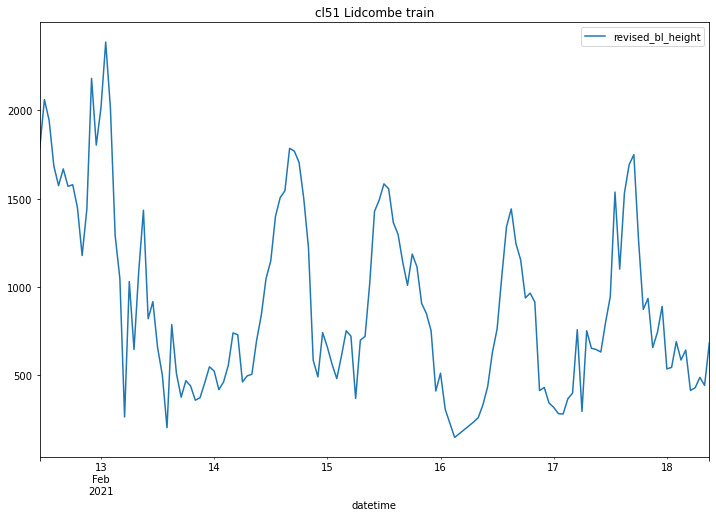

                                     SARIMAX Results                                      
Dep. Variable:                  revised_bl_height   No. Observations:                  143
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood                -838.365
Date:                            Wed, 15 Sep 2021   AIC                           1686.731
Time:                                    15:05:24   BIC                           1700.584
Sample:                                02-12-2021   HQIC                          1692.355
                                     - 02-18-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1649      0.693     -0.238      0.812      -1.523       1.193
ma.L1          0.0262      0.678   

C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\thoma\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency inform

At Lidcombe
Index of agreement:0.91012
Root mean squared error:161.91527
Mean absoluate error:141.05746
Mean bias error:20.69927
DTW distance:3235.86
Mean absolute scaled error:0.81170


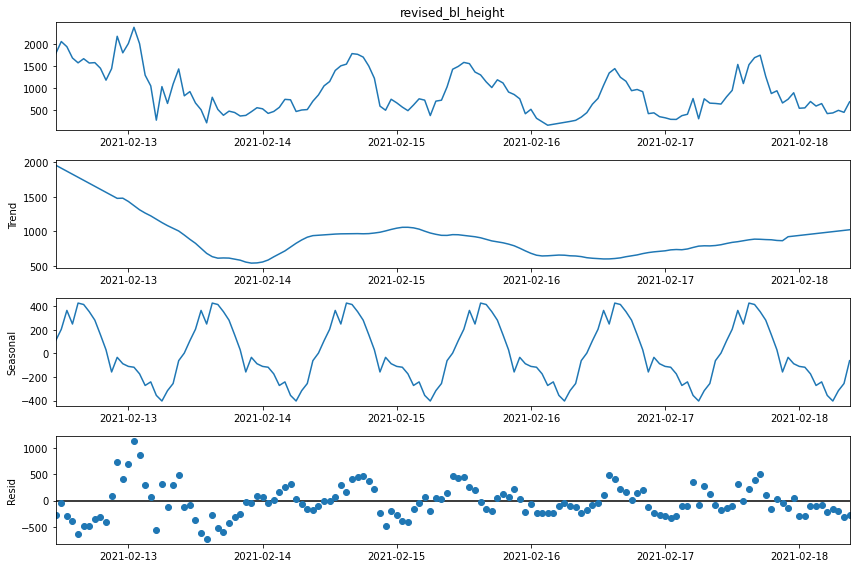

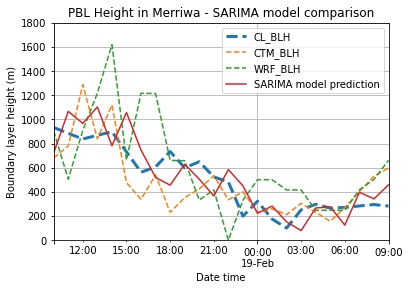

In [60]:
df_merriwa = join_CL_CTM_WRF('Merriwa', wrf_df_merriwa)

cl51_Merriwa = data_process()

ARIMA_model(cl51_Merriwa, df_merriwa)